In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, RNN, Dense, Dropout

2025-05-20 17:07:38.834771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747760859.090301      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747760859.161502      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import wandb
from wandb.integration.keras import WandbCallback

wandb.login(key='e030007b097df00d9a751748294abc8440f932b1')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b044 (mm21b044-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Question 1

In [5]:
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None, names=['latin', 'native'])
    df = df.dropna()
    df['latin'] = df['latin'].astype(str)
    df['native'] = df['native'].astype(str)
    return df

def load_dakshina_dataset(language_code='hi', base_dir='/kaggle/input/dak-data/dakshina_dataset_v1.0'):
    path = os.path.join(base_dir, language_code, 'lexicons')
    return (
        load_data(os.path.join(path, f'{language_code}.translit.sampled.train.tsv')),
        load_data(os.path.join(path, f'{language_code}.translit.sampled.dev.tsv')),
        load_data(os.path.join(path, f'{language_code}.translit.sampled.test.tsv')),
    )

train_data, val_data, test_data = load_dakshina_dataset()

# ─── 1) Extract raw texts ─────────────────────────────────────────
input_texts  = train_data['latin'].tolist()
target_texts = ['\t' + t + '\n' for t in train_data['native'].tolist()]

val_input_texts  = val_data['latin'].tolist()
val_target_texts = ['\t' + t + '\n' for t in val_data['native'].tolist()]

input_tokenizer = Tokenizer(char_level=True, oov_token=None)
input_tokenizer.fit_on_texts(input_texts + val_input_texts)

target_tokenizer = Tokenizer(char_level=True, oov_token=None)
target_tokenizer.fit_on_texts(target_texts + val_target_texts)

# ─── 3) Convert texts → integer sequences + pad to max lengths ───
# Compute max lengths
max_in  = max(len(txt) for txt in input_texts + val_input_texts)
max_out = max(len(txt) for txt in target_texts + val_target_texts)

# Integer‑encode + pad
encoder_input_train = pad_sequences(
    input_tokenizer.texts_to_sequences(input_texts),
    maxlen=max_in,
    padding='post'
)
decoder_input_train = pad_sequences(
    target_tokenizer.texts_to_sequences(target_texts),
    maxlen=max_out,
    padding='post'
)
# decoder targets are the decoder inputs shifted left by one
decoder_target_train = np.array(decoder_input_train)[:, 1:]
decoder_input_train   = np.array(decoder_input_train)[:, :-1]

# Do the same for validation set
encoder_input_val = pad_sequences(
    input_tokenizer.texts_to_sequences(val_input_texts),
    maxlen=max_in,
    padding='post'
)
decoder_input_val = pad_sequences(
    target_tokenizer.texts_to_sequences(val_target_texts),
    maxlen=max_out,
    padding='post'
)
decoder_target_val = np.array(decoder_input_val)[:, 1:]
decoder_input_val   = np.array(decoder_input_val)[:, :-1]

# Make sure any previous wandb runs are finished
try:
    wandb.finish()
except:
    pass

# Initialize wandb with proper error handling
try:
    wandb.init(
        project="DA_seq2seq_transliteration",
        name="vanilla_lstm_run_q1",
        # Removed reinit=True to prevent connection issues
        config={
            "model_type": "vanilla",
            "cell_type": "LSTM",
            "embedding_dim": 64,
            "hidden_dim": 128,
            "dropout_rate": 0.2,
            "batch_size": 64,
            "epochs": 10,
            "input_vocab_size": len(input_tokenizer.word_index) + 1,
            "target_vocab_size": len(target_tokenizer.word_index) + 1,
            "max_input_length": max_in,
            "max_target_length": max_out,
            "optimizer": "adam",
            "loss": "sparse_categorical_crossentropy",
            "dataset": "dakshina_hi"
        }
    )
except Exception as e:
    print(f"Failed to initialize wandb: {e}")
    # Create a dummy wandb to avoid errors in the code
    class DummyWandb:
        def log(self, *args, **kwargs):
            pass
        def config(self, *args, **kwargs):
            return type('obj', (object,), {
                'embedding_dim': 64,
                'hidden_dim': 128,
                'get': lambda s, k, d: d
            })
    wandb = DummyWandb()

class VanillaSeq2Seq:
    def __init__(self,
                 input_vocab_size,
                 target_vocab_size,
                 embedding_dim,
                 hidden_dim,
                 cell_type='LSTM',
                 dropout_rate=0.2,
                 num_encoder_layers=1,
                 num_decoder_layers=1):
        self.input_vocab_size  = input_vocab_size
        self.target_vocab_size = target_vocab_size
        self.embedding_dim     = embedding_dim
        self.hidden_dim        = hidden_dim
        self.cell_type         = cell_type
        self.dropout_rate      = dropout_rate
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.model = self._build_model()

    def _rnn_layer(self, return_sequences, return_state):
        """Factory for one RNN/LSTM/GRU layer."""
        if self.cell_type == 'LSTM':
            return LSTM(self.hidden_dim,
                        return_sequences=return_sequences,
                        return_state=return_state)
        elif self.cell_type == 'GRU':
            return GRU(self.hidden_dim,
                       return_sequences=return_sequences,
                       return_state=return_state)
        else:
            return RNN(self.hidden_dim,
                       return_sequences=return_sequences,
                       return_state=return_state)

    def _build_model(self):
        encoder_inputs = Input(shape=(None,), name='encoder_input')
        x = Embedding(self.input_vocab_size, self.embedding_dim)(encoder_inputs)
        x = Dropout(self.dropout_rate)(x)

        # Stack encoder layers
        encoder_states = []
        for i in range(self.num_encoder_layers):
            # last encoder layer returns only state, earlier ones return sequences
            rs = (i < self.num_encoder_layers - 1)
            if self.cell_type == 'LSTM':
                x, state_h, state_c = LSTM(
                    self.hidden_dim,
                    return_sequences=rs,
                    return_state=True,
                    name=f'enc_lstm_{i}'
                )(x)
                encoder_states = [state_h, state_c]
            else:
                x, state_h = self._rnn_layer(
                    return_sequences=rs,
                    return_state=True
                )(x)
                encoder_states = [state_h]

        decoder_inputs = Input(shape=(None,), name='decoder_input')
        y = Embedding(self.target_vocab_size, self.embedding_dim)(decoder_inputs)
        y = Dropout(self.dropout_rate)(y)

        # Stack decoder layers
        for i in range(self.num_decoder_layers):
            rs = True  # decoder always returns sequences for all but we only care about final dense
            if self.cell_type == 'LSTM':
                # feed initial_state only to the first decoder layer
                init_st = encoder_states if i == 0 else None
                y, dh, dc = LSTM(
                    self.hidden_dim,
                    return_sequences=True,
                    return_state=True,
                    name=f'dec_lstm_{i}'
                )(y, initial_state=init_st) if init_st else LSTM(
                    self.hidden_dim,
                    return_sequences=True,
                    return_state=True,
                    name=f'dec_lstm_{i}'
                )(y)
            else:
                init_st = encoder_states if i == 0 else None
                y, dh = self._rnn_layer(
                    return_sequences=True,
                    return_state=True
                )(y, initial_state=init_st) if init_st else self._rnn_layer(
                    return_sequences=True,
                    return_state=True
                )(y)

        # Final projection
        outputs = Dense(self.target_vocab_size, activation='softmax')(y)
        return Model([encoder_inputs, decoder_inputs], outputs)

    def compile(self, optimizer='adam', loss='sparse_categorical_crossentropy'):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    def fit(self, train_data, val_data, batch_size=64, epochs=8, callbacks=None):
        return self.model.fit(
            [train_data['encoder_input'], train_data['decoder_input']],
            np.expand_dims(train_data['decoder_target'], -1),
            validation_data=(
                [val_data['encoder_input'], val_data['decoder_input']],
                np.expand_dims(val_data['decoder_target'], -1)
            ),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks
        )
        
input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

model = VanillaSeq2Seq(
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    embedding_dim=64,
    hidden_dim=128,
    cell_type='LSTM',
    dropout_rate=0.2
)

model.compile()

# Modified wandb callback with error handling
try:
    wandb_callback = WandbCallback(
        log_model=False,           # no wandb artifact
        save_graph=False,          # don't try to render graph
        save_model=False           # ✅ disables all auto saving
    )
    callbacks = [wandb_callback]
except Exception as e:
    print(f"Failed to initialize WandbCallback: {e}")
    callbacks = []

# Use try-except for wandb config access
try:
    D = wandb.config.embedding_dim
    H = wandb.config.hidden_dim
    L_e = wandb.config.get("num_encoder_layers", 1)
    L_d = wandb.config.get("num_decoder_layers", 1)
except Exception as e:
    print(f"Failed to access wandb config: {e}")
    D = 64  # Default values
    H = 128
    L_e = 1
    L_d = 1

T_enc = encoder_input_train.shape[1]
T_dec = decoder_input_train.shape[1]

flops_per_step = 4 * (H * D + H * H)

# 4) Total ops over all layers & timesteps
total_enc_flops = L_e * T_enc * flops_per_step
total_dec_flops = L_d * T_dec * flops_per_step
total_flops = total_enc_flops + total_dec_flops

print(f"Approximate total multiplications (encoder + decoder): {total_flops:,}")

total_params = model.model.count_params()
print(f"Total trainable parameters: {total_params:,}")

model.model.summary()

history = model.fit(
    train_data={
        'encoder_input': encoder_input_train,
        'decoder_input': decoder_input_train,
        'decoder_target': decoder_target_train
    },
    val_data={
        'encoder_input': encoder_input_val,
        'decoder_input': decoder_input_val,
        'decoder_target': decoder_target_val
    },
    batch_size=64,
    epochs=8,
    callbacks=callbacks
)

# Log metrics to wandb with error handling
try:
    wandb.log({
        "total_flops": total_flops,
        "total_trainable_params": total_params
    })
    # Properly close the wandb run
    wandb.finish()
except Exception as e:
    print(f"Failed to log to wandb: {e}")

I0000 00:00:1747749727.720180      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747749727.720823      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Approximate total multiplications (encoder + decoder): 2,260,992
Total trainable parameters: 201,869


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 64)       │          1,728 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 64)       │            832 │ decoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, None, 64)       │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 64)       │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_lstm_0 (LSTM)         │ [(None, 128), (None,   │         98,816 │ dropout[0][0]          │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec_lstm_0 (LSTM)         │ [(None, None, 128),    │         98,816 │ dropout_1[0][0],       │
│                           │ (None, 128), (None,    │                │ enc_lstm_0[0][1],      │
│                           │ 128)]                  │                │ enc_lstm_0[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 13)       │          1,677 │ dec_lstm_0[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 201,869 (788.55 KB)

 Trainable params: 201,869 (788.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8


I0000 00:00:1747749734.614468     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


691/691 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7907 - loss: 0.6139 - val_accuracy: 0.8282 - val_loss: 0.3884
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8258 - loss: 0.4008 - val_accuracy: 0.8293 - val_loss: 0.3774
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8283 - loss: 0.3912 - val_accuracy: 0.8322 - val_loss: 0.3763
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8310 - loss: 0.3900 - val_accuracy: 0.8346 - val_loss: 0.3753
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8341 - loss: 0.3864 - val_accuracy: 0.8374 - val_loss: 0.3713
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8370 - loss: 0.3810 - val_accuracy: 0.8403 - val_loss: 0.3711
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8407 - loss: 0.3774 - val_accuracy: 0.8440 - val_loss: 0.3640
Epoch 8/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8410 - loss: 0.3755 - val_accuracy: 0.8440 - val_loss: 

accuracy,▁▃▄▅▆▇██
epoch,▁▂▃▄▅▆▇█
loss,█▃▂▂▂▂▁▁
total_flops,▁
total_trainable_params,▁
val_accuracy,▁▁▃▄▅▆██
val_loss,█▅▅▄▃▃▁▁
accuracy,0.84121
best_epoch,7
best_val_loss,0.36256
epoch,7


# Question 2

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Model
import os
import time
import matplotlib.pyplot as plt

In [7]:
# Load the Dakshina dataset (Hindi as an example)
# You can change 'hi' to the language of your choice
def load_dakshina_data(lang='hi'):
    base_path = f'/kaggle/input/dak-data/dakshina_dataset_v1.0/{lang}/lexicons/'
    
    # Load train, dev, test sets
    train_data = pd.read_csv(f'{base_path}{lang}.translit.sampled.train.tsv', sep='\t', 
                             header=None, names=['latin', 'native', 'class'])
    val_data = pd.read_csv(f'{base_path}{lang}.translit.sampled.dev.tsv', sep='\t', 
                           header=None, names=['latin', 'native', 'class'])
    test_data = pd.read_csv(f'{base_path}{lang}.translit.sampled.test.tsv', sep='\t', 
                            header=None, names=['latin', 'native', 'class'])

    # Drop any rows with missing values
    train_data = train_data.dropna().astype(str)
    val_data   = val_data.dropna().astype(str)
    test_data  = test_data.dropna().astype(str)

    return train_data, val_data, test_data

# Process data and create sequences
def process_data(train_data, val_data):
    # Extract texts
    input_texts = train_data['latin'].tolist()
    target_texts = ['\t' + t + '\n' for t in train_data['native'].tolist()]
    
    val_input_texts = val_data['latin'].tolist()
    val_target_texts = ['\t' + t + '\n' for t in val_data['native'].tolist()]
    
    # Build character-level tokenizers
    input_tokenizer = Tokenizer(char_level=True, oov_token=None)
    input_tokenizer.fit_on_texts(input_texts + val_input_texts)
    
    target_tokenizer = Tokenizer(char_level=True, oov_token=None)
    target_tokenizer.fit_on_texts(target_texts + val_target_texts)
    
    # Find max lengths
    max_in = max(len(txt) for txt in input_texts + val_input_texts)
    max_out = max(len(txt) for txt in target_texts + val_target_texts)
    
    # Convert to sequences and pad
    encoder_input_train = pad_sequences(
        input_tokenizer.texts_to_sequences(input_texts),
        maxlen=max_in,
        padding='post'
    )
    decoder_input_train = pad_sequences(
        target_tokenizer.texts_to_sequences(target_texts),
        maxlen=max_out,
        padding='post'
    )
    decoder_target_train = np.array(decoder_input_train)[:, 1:]
    decoder_input_train = np.array(decoder_input_train)[:, :-1]
    
    # Same for validation set
    encoder_input_val = pad_sequences(
        input_tokenizer.texts_to_sequences(val_input_texts),
        maxlen=max_in,
        padding='post'
    )
    decoder_input_val = pad_sequences(
        target_tokenizer.texts_to_sequences(val_target_texts),
        maxlen=max_out,
        padding='post'
    )
    decoder_target_val = np.array(decoder_input_val)[:, 1:]
    decoder_input_val = np.array(decoder_input_val)[:, :-1]
    
    return {
        'input_tokenizer': input_tokenizer,
        'target_tokenizer': target_tokenizer,
        'max_in': max_in,
        'max_out': max_out,
        'encoder_input_train': encoder_input_train,
        'decoder_input_train': decoder_input_train,
        'decoder_target_train': decoder_target_train,
        'encoder_input_val': encoder_input_val,
        'decoder_input_val': decoder_input_val,
        'decoder_target_val': decoder_target_val,
        'input_texts': input_texts,
        'target_texts': target_texts,
        'val_input_texts': val_input_texts,
        'val_target_texts': val_target_texts
    }

# Seq2Seq model with configurable parameters
class VanillaSeq2Seq:
    def __init__(self,
                 input_vocab_size,
                 target_vocab_size,
                 embedding_dim,
                 hidden_dim,
                 cell_type='LSTM',
                 dropout_rate=0.2,
                 num_encoder_layers=1,
                 num_decoder_layers=1):
        self.input_vocab_size = input_vocab_size
        self.target_vocab_size = target_vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type
        self.dropout_rate = dropout_rate
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.model = self._build_model()
        
    def _rnn_layer(self, return_sequences, return_state):
        """Factory for one RNN/LSTM/GRU layer."""
        if self.cell_type == 'LSTM':
            return LSTM(self.hidden_dim,
                        return_sequences=return_sequences,
                        return_state=return_state)
        elif self.cell_type == 'GRU':
            return GRU(self.hidden_dim,
                       return_sequences=return_sequences,
                       return_state=return_state)
        else:  # 'RNN'
            return SimpleRNN(self.hidden_dim,
                             return_sequences=return_sequences,
                             return_state=return_state)

    
    def _build_model(self):
        encoder_inputs = Input(shape=(None,), name='encoder_input')
        x = Embedding(self.input_vocab_size, self.embedding_dim)(encoder_inputs)
        x = Dropout(self.dropout_rate)(x)
        
        # Stack encoder layers
        encoder_states = []
        for i in range(self.num_encoder_layers):
            # last encoder layer returns only state, earlier ones return sequences
            rs = (i < self.num_encoder_layers - 1)
            if self.cell_type == 'LSTM':
                x, state_h, state_c = LSTM(
                    self.hidden_dim,
                    return_sequences=rs,
                    return_state=True,
                    name=f'enc_lstm_{i}'
                )(x)
                encoder_states = [state_h, state_c]
            else:
                x, state_h = self._rnn_layer(
                    return_sequences=rs,
                    return_state=True
                )(x)
                encoder_states = [state_h]
        
        decoder_inputs = Input(shape=(None,), name='decoder_input')
        y = Embedding(self.target_vocab_size, self.embedding_dim)(decoder_inputs)
        y = Dropout(self.dropout_rate)(y)
        
        # Stack decoder layers
        for i in range(self.num_decoder_layers):
            rs = True  # decoder always returns sequences
            if self.cell_type == 'LSTM':
                # feed initial_state only to the first decoder layer
                init_st = encoder_states if i == 0 else None
                y, dh, dc = LSTM(
                    self.hidden_dim, 
                    return_sequences=True,
                    return_state=True,
                    name=f'dec_lstm_{i}'
                )(y, initial_state=init_st) if init_st else LSTM(
                    self.hidden_dim,
                    return_sequences=True,
                    return_state=True,
                    name=f'dec_lstm_{i}'
                )(y)
            else:
                init_st = encoder_states if i == 0 else None
                y, dh = self._rnn_layer(
                    return_sequences=True,
                    return_state=True
                )(y, initial_state=init_st) if init_st else self._rnn_layer(
                    return_sequences=True,
                    return_state=True
                )(y)
        
        # Final projection
        outputs = Dense(self.target_vocab_size, activation='softmax')(y)
        return Model([encoder_inputs, decoder_inputs], outputs)
    
    def compile(self, optimizer='adam', loss='sparse_categorical_crossentropy'):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        
    def fit(self, train_data, val_data, batch_size=64, epochs=8, callbacks=None):
        return self.model.fit(
            [train_data['encoder_input'], train_data['decoder_input']],
            np.expand_dims(train_data['decoder_target'], -1),
            validation_data=(
                [val_data['encoder_input'], val_data['decoder_input']],
                np.expand_dims(val_data['decoder_target'], -1)
            ),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks
        )

def run_wandb_sweep(processed_data):
    # Define sweep configuration
    sweep_config = {
        'method': 'bayes',
        'metric': {
            'name': 'val_accuracy',
            'goal': 'maximize'
        },
        'parameters': {
            'embedding_dim': {
                'values': [16, 32, 64, 128]
            },
            'hidden_dim': {
                'values': [32, 64, 128, 256]
            },
            'cell_type': {
                'values': ['RNN', 'GRU', 'LSTM']
            },
            'dropout_rate': {
                'values': [0.1, 0.2, 0.3]
            },
            'num_encoder_layers': {
                'values': [1, 2]
            },
            'num_decoder_layers': {
                'values': [1, 2]
            }
        }
    }
    
    # Initialize sweep
    sweep_id = wandb.sweep(sweep_config, project="DA_seq2seq_transliteration")
    
    # Define the training function
    def train_model():
        # Make sure we're in a clean wandb state
        try:
            wandb.finish()
        except:
            pass
        
        # Start a new wandb run
        run = wandb.init()
        
        # Access hyperparameters from wandb
        config = wandb.config
        
        # Create model with hyperparameters from wandb
        input_vocab_size = len(processed_data['input_tokenizer'].word_index) + 1
        target_vocab_size = len(processed_data['target_tokenizer'].word_index) + 1
        
        model = VanillaSeq2Seq(
            input_vocab_size=input_vocab_size,
            target_vocab_size=target_vocab_size,
            embedding_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            cell_type=config.cell_type,
            dropout_rate=config.dropout_rate,
            num_encoder_layers=config.num_encoder_layers,
            num_decoder_layers=config.num_decoder_layers
        )
        
        model.compile()
        
        # Configure wandb callback
        wandb_callback = WandbCallback(
            log_model=False,
            save_graph=False,
            save_model=False
        )
        
        # Compute model complexity metrics
        D = config.embedding_dim
        H = config.hidden_dim
        L_e = config.num_encoder_layers
        L_d = config.num_decoder_layers
        T_enc = processed_data['encoder_input_train'].shape[1]
        T_dec = processed_data['decoder_input_train'].shape[1]
        
        flops_per_step = 4 * (H * D + H * H)
        total_enc_flops = L_e * T_enc * flops_per_step
        total_dec_flops = L_d * T_dec * flops_per_step
        total_flops = total_enc_flops + total_dec_flops
        
        total_params = model.model.count_params()
        
        print(f"Embedding dim: {D}, Hidden dim: {H}")
        print(f"Encoder layers: {L_e}, Decoder layers: {L_d}")
        print(f"Cell type: {config.cell_type}, Dropout: {config.dropout_rate}")
        print(f"Total parameters: {total_params:,}")
        print(f"Total FLOPs: {total_flops:,}")
        
        # Log model complexity metrics
        wandb.log({
            "total_flops": total_flops,
            "total_params": total_params
        })
        
        # Train the model
        start_time = time.time()
        
        history = model.fit(
            train_data={
                'encoder_input': processed_data['encoder_input_train'],
                'decoder_input': processed_data['decoder_input_train'],
                'decoder_target': processed_data['decoder_target_train']
            },
            val_data={
                'encoder_input': processed_data['encoder_input_val'],
                'decoder_input': processed_data['decoder_input_val'],
                'decoder_target': processed_data['decoder_target_val']
            },
            batch_size=64,
            epochs=8,
            callbacks=[wandb_callback]
        )
        
        training_time = time.time() - start_time
        
        # Log additional metrics
        wandb.log({
            "training_time": training_time,
            "final_train_accuracy": history.history['accuracy'][-1],
            "final_val_accuracy": history.history['val_accuracy'][-1]
        })
        
        # Clean up (important to avoid memory leaks)
        tf.keras.backend.clear_session()
        run.finish()
    
    # Run the sweep
    wandb.agent(sweep_id, train_model, count=7)  # Adjust count based on time constraints

In [6]:
# Main execution
if __name__ == "__main__":
    # Ensure TensorFlow doesn't reserve all GPU memory
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    
    # Load data
    try:
        train_data, val_data, test_data = load_dakshina_data(lang='hi')
        print(f"Data loaded successfully! Train size: {len(train_data)}")
        
        # Process data
        processed_data = process_data(train_data, val_data)
        print("Data processed successfully!")
        
        # Run sweep
        print("Starting hyperparameter sweep...")
        run_wandb_sweep(processed_data)
        
    except Exception as e:
        print(f"Error: {str(e)}")

Data loaded successfully! Train size: 44202
Data processed successfully!
Starting hyperparameter sweep...
Create sweep with ID: mpq5soqm
Sweep URL: https://wandb.ai/mm21b044-indian-institute-of-technology-madras/DA_seq2seq_transliteration/sweeps/mpq5soqm


wandb: Agent Starting Run: inksfj02 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout_rate: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Embedding dim: 64, Hidden dim: 256
Encoder layers: 2, Decoder layers: 1
Cell type: LSTM, Dropout: 0.3
Total parameters: 1,196,125
Total FLOPs: 19,333,120
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 143s 196ms/step - accuracy: 0.7037 - loss: 1.1084 - val_accuracy: 0.7615 - val_loss: 0.7974
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 134s 194ms/step - accuracy: 0.7614 - loss: 0.7937 - val_accuracy: 0.8196 - val_loss: 0.5974
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 135s 196ms/step - accuracy: 0.8165 - loss: 0.5964 - val_accuracy: 0.8607 - val_loss: 0.4616
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 137s 198ms/step - accuracy: 0.8617 - loss: 0.4554 - val_accuracy: 0.9029 - val_loss: 0.3273
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 135s 196ms/step - accuracy: 0.8995 - loss: 0.3332 - val_accuracy: 0.9259 - val_loss: 0.2486
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 132s 191ms/step - accuracy: 0.9226 - loss: 0.2538 - val_accuracy: 0.9383 - val_loss: 0.2057
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 134s 193ms/step - acc

accuracy,▁▂▄▆▇▇██
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▆▅▃▂▂▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▃▅▆▇███
val_loss,█▆▄▃▂▁▁▁
accuracy,0.9442


wandb: Agent Starting Run: 0r31b8ft with config:
wandb: 	cell_type: GRU
wandb: 	dropout_rate: 0.2
wandb: 	embedding_dim: 16
wandb: 	hidden_dim: 32
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 1


Embedding dim: 16, Hidden dim: 32
Encoder layers: 1, Decoder layers: 2
Cell type: GRU, Dropout: 0.2
Total parameters: 18,381
Total FLOPs: 374,784
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.6691 - loss: 1.3930 - val_accuracy: 0.7426 - val_loss: 0.8798
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7361 - loss: 0.9034 - val_accuracy: 0.7523 - val_loss: 0.8497
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.7413 - loss: 0.8765 - val_accuracy: 0.7572 - val_loss: 0.8311
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.7448 - loss: 0.8618 - val_accuracy: 0.7588 - val_loss: 0.8153
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7476 - loss: 0.8472 - val_accuracy: 0.7629 - val_loss: 0.7999
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.7528 - loss: 0.8329 - val_accuracy: 0.7690 - val_loss: 0.7848
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.7580 - loss: 

accuracy,▁▅▅▆▆▇▇█
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▃▃▃▂▂▂▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▃▄▄▅▆▇█
val_loss,█▇▆▅▄▄▂▁
accuracy,0.76626


wandb: Agent Starting Run: hwigli45 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout_rate: 0.2
wandb: 	embedding_dim: 16
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1


Embedding dim: 16, Hidden dim: 256
Encoder layers: 1, Decoder layers: 1
Cell type: LSTM, Dropout: 0.2
Total parameters: 568,045
Total FLOPs: 11,141,120
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - accuracy: 0.6936 - loss: 1.1958 - val_accuracy: 0.7601 - val_loss: 0.8091
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 77s 112ms/step - accuracy: 0.7529 - loss: 0.8280 - val_accuracy: 0.7808 - val_loss: 0.7201
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 79s 114ms/step - accuracy: 0.7740 - loss: 0.7476 - val_accuracy: 0.8014 - val_loss: 0.6486
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 79s 115ms/step - accuracy: 0.7905 - loss: 0.6829 - val_accuracy: 0.8204 - val_loss: 0.5936
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 95s 137ms/step - accuracy: 0.8057 - loss: 0.6309 - val_accuracy: 0.8310 - val_loss: 0.5477
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 83s 119ms/step - accuracy: 0.8207 - loss: 0.5749 - val_accuracy: 0.8410 - val_loss: 0.5050
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 81s 117ms/step - accuracy: 0.

accuracy,▁▃▄▅▆▆▇█
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▆▅▄▃▂▂▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▂▃▅▅▆▇█
val_loss,█▇▅▄▄▃▂▁
accuracy,0.85587


wandb: Agent Starting Run: sydm6xg4 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout_rate: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2


Embedding dim: 64, Hidden dim: 256
Encoder layers: 2, Decoder layers: 2
Cell type: LSTM, Dropout: 0.3
Total parameters: 1,721,437
Total FLOPs: 26,214,400
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 206s 284ms/step - accuracy: 0.6965 - loss: 1.1433 - val_accuracy: 0.7635 - val_loss: 0.7950
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 190s 275ms/step - accuracy: 0.7635 - loss: 0.7890 - val_accuracy: 0.8123 - val_loss: 0.6225
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 193s 279ms/step - accuracy: 0.8136 - loss: 0.6096 - val_accuracy: 0.8693 - val_loss: 0.4282
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 191s 276ms/step - accuracy: 0.8685 - loss: 0.4264 - val_accuracy: 0.9098 - val_loss: 0.2975
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 188s 273ms/step - accuracy: 0.9052 - loss: 0.3063 - val_accuracy: 0.9304 - val_loss: 0.2281
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 188s 272ms/step - accuracy: 0.9284 - loss: 0.2319 - val_accuracy: 0.9400 - val_loss: 0.1944
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 191s 276ms/step - acc

accuracy,▁▃▄▆▇▇██
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▆▄▃▂▂▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▃▅▇▇███
val_loss,█▆▄▂▂▁▁▁
accuracy,0.94798


wandb: Agent Starting Run: 1da0cgf0 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout_rate: 0.3
wandb: 	embedding_dim: 128
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2


Embedding dim: 128, Hidden dim: 256
Encoder layers: 2, Decoder layers: 2
Cell type: LSTM, Dropout: 0.3
Total parameters: 1,858,461
Total FLOPs: 31,457,280
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 211s 290ms/step - accuracy: 0.6999 - loss: 1.1278 - val_accuracy: 0.7640 - val_loss: 0.7907
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 195s 282ms/step - accuracy: 0.7704 - loss: 0.7635 - val_accuracy: 0.8331 - val_loss: 0.5421
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 195s 283ms/step - accuracy: 0.8366 - loss: 0.5290 - val_accuracy: 0.8907 - val_loss: 0.3595
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 195s 283ms/step - accuracy: 0.8925 - loss: 0.3483 - val_accuracy: 0.9280 - val_loss: 0.2395
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 206s 289ms/step - accuracy: 0.9258 - loss: 0.2404 - val_accuracy: 0.9406 - val_loss: 0.1942
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 199s 288ms/step - accuracy: 0.9410 - loss: 0.1892 - val_accuracy: 0.9475 - val_loss: 0.1709
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 197s 286ms/step - ac

accuracy,▁▃▅▆▇███
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▆▄▃▂▁▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▄▆▇████
val_loss,█▅▃▂▁▁▁▁
accuracy,0.95375


wandb: Agent Starting Run: vihxk2yq with config:
wandb: 	cell_type: GRU
wandb: 	dropout_rate: 0.1
wandb: 	embedding_dim: 128
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2


Embedding dim: 128, Hidden dim: 256
Encoder layers: 2, Decoder layers: 1
Cell type: GRU, Dropout: 0.1
Total parameters: 1,007,005
Total FLOPs: 23,199,744
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - accuracy: 0.7157 - loss: 1.0475 - val_accuracy: 0.7969 - val_loss: 0.6725
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 124s 179ms/step - accuracy: 0.8153 - loss: 0.6139 - val_accuracy: 0.8872 - val_loss: 0.3759
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 123s 178ms/step - accuracy: 0.8920 - loss: 0.3576 - val_accuracy: 0.9281 - val_loss: 0.2485
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 121s 175ms/step - accuracy: 0.9271 - loss: 0.2398 - val_accuracy: 0.9403 - val_loss: 0.1994
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 122s 176ms/step - accuracy: 0.9407 - loss: 0.1928 - val_accuracy: 0.9415 - val_loss: 0.1880
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 123s 178ms/step - accuracy: 0.9468 - loss: 0.1675 - val_accuracy: 0.9477 - val_loss: 0.1733
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 124s 179ms/step - acc

accuracy,▁▄▆▇████
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▅▃▂▁▁▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▅▇█████
val_loss,█▄▂▂▁▁▁▁
accuracy,0.95386


wandb: Agent Starting Run: 6n1ssi28 with config:
wandb: 	cell_type: GRU
wandb: 	dropout_rate: 0.3
wandb: 	embedding_dim: 128
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2


Embedding dim: 128, Hidden dim: 256
Encoder layers: 2, Decoder layers: 1
Cell type: GRU, Dropout: 0.3
Total parameters: 1,007,005
Total FLOPs: 23,199,744
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 141s 190ms/step - accuracy: 0.7152 - loss: 1.0636 - val_accuracy: 0.7932 - val_loss: 0.6926
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 126s 183ms/step - accuracy: 0.8013 - loss: 0.6613 - val_accuracy: 0.8663 - val_loss: 0.4354
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.8725 - loss: 0.4221 - val_accuracy: 0.9152 - val_loss: 0.2891
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 125s 181ms/step - accuracy: 0.9130 - loss: 0.2876 - val_accuracy: 0.9335 - val_loss: 0.2224
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 122s 176ms/step - accuracy: 0.9320 - loss: 0.2232 - val_accuracy: 0.9418 - val_loss: 0.1931
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 121s 175ms/step - accuracy: 0.9407 - loss: 0.1891 - val_accuracy: 0.9459 - val_loss: 0.1762
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 121s 175ms/step - acc

accuracy,▁▄▆▇▇███
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▅▃▂▂▁▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▄▆▇████
val_loss,█▅▃▂▁▁▁▁
accuracy,0.94977


# Question 4

In [14]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks as keras_cb
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbCallback

# ─── A) Bring data & tokenizers back into scope ───────────────────
try:
    pi = processed_data
    input_tokenizer  = pi['input_tokenizer']
    target_tokenizer = pi['target_tokenizer']
    max_in, max_out = pi['max_in'], pi['max_out']
    encoder_input_train = pi['encoder_input_train']
    decoder_input_train = pi['decoder_input_train']
    decoder_target_train= pi['decoder_target_train']
    encoder_input_val   = pi['encoder_input_val']
    decoder_input_val   = pi['decoder_input_val']
    decoder_target_val  = pi['decoder_target_val']
    print("✅ Data and tokenizers loaded from cache.")
except NameError:
    train_data, val_data, test_data = load_dakshina_data(lang='hi')
    pi = process_data(train_data, val_data)
    input_tokenizer  = pi['input_tokenizer']
    target_tokenizer = pi['target_tokenizer']
    max_in, max_out = pi['max_in'], pi['max_out']
    encoder_input_train = pi['encoder_input_train']
    decoder_input_train = pi['decoder_input_train']
    decoder_target_train= pi['decoder_target_train']
    encoder_input_val   = pi['encoder_input_val']
    decoder_input_val   = pi['decoder_input_val']
    decoder_target_val  = pi['decoder_target_val']
    print("✅ Data processed and tokenizers created.")
print("✅ Step A complete")

# ─── B) Fetch best hyperparams ─────────────────────────────
api    = wandb.Api()
ENTITY = "mm21b044-indian-institute-of-technology-madras"
PROJ   = "DA_seq2seq_transliteration"

print("🔍 Fetching wandb runs...")
all_runs   = api.runs(f"{ENTITY}/{PROJ}")
valid_runs = [r for r in all_runs if 'final_val_accuracy' in r.summary]
best_run   = max(valid_runs, key=lambda r: r.summary['final_val_accuracy'])
best_cfg   = best_run.config

print(f"✅ Best run: {best_run.id} with val_accuracy={best_run.summary['final_val_accuracy']:.4f}")
print("Best sweep config:", best_cfg)

inp_vocab = len(input_tokenizer.word_index) + 1
tgt_vocab = len(target_tokenizer.word_index) + 1

BEST_HP = {
    'input_vocab_size':   inp_vocab,
    'target_vocab_size':  tgt_vocab,
    'embedding_dim':      best_cfg['embedding_dim'],
    'hidden_dim':         best_cfg['hidden_dim'],
    'cell_type':          best_cfg['cell_type'],
    'dropout_rate':       best_cfg['dropout_rate'],
    'num_encoder_layers': best_cfg.get('num_encoder_layers', 1),
    'num_decoder_layers': best_cfg.get('num_decoder_layers', 1)
}
print("✅ Step B complete")

# ─── C) Rebuild model ─────────────────────────────────────────────
print("🔧 Rebuilding model...")
model = VanillaSeq2Seq(**BEST_HP)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
print("✅ Model built and compiled.")

# ─── D) Prepare for retraining ───────────────────────────────────
y_train = np.expand_dims(decoder_target_train, -1)
y_val   = np.expand_dims(decoder_target_val, -1)

wandb.init(project=PROJ, name="q4_retrain_best_model", reinit=True)
wandb.config.update(BEST_HP, allow_val_change=True)

checkpoint_path = "/kaggle/working/q4_best_model.weights.h5"
cb = [
    keras_cb.ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss'
    ),
    WandbCallback(
        save_model=False,
        log_weights=True,
        save_graph=False
    )
]
print("✅ Step D complete. Beginning training...")

# ─── E) Retrain ───────────────────────────────────────────────────
history = model.model.fit(
    [encoder_input_train, decoder_input_train],
    y_train,
    batch_size=wandb.config.get('batch_size', 64),
    epochs=10,
    validation_data=([encoder_input_val, decoder_input_val], y_val),
    callbacks=cb,
    verbose=1
)
print("✅ Training complete")

wandb.finish()
print("✅ wandb finished")

# ─── F) Load weights and prepare test ─────────────────────────────
model.model.load_weights(checkpoint_path)
print("✅ Weights loaded")

✅ Data processed and tokenizers created.
✅ Step A complete
🔍 Fetching wandb runs...
✅ Best run: s35s9ajw with val_accuracy=0.9523
Best sweep config: {'cell_type': 'LSTM', 'hidden_dim': 256, 'dropout_rate': 0.1, 'embedding_dim': 128, 'num_decoder_layers': 1, 'num_encoder_layers': 2}
✅ Step B complete
🔧 Rebuilding model...
✅ Model built and compiled.


✅ Step D complete. Beginning training...
Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7129 - loss: 1.0550 - val_accuracy: 0.7994 - val_loss: 0.6679
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8086 - loss: 0.6327 - val_accuracy: 0.8680 - val_loss: 0.4357
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8765 - loss: 0.4036 - val_accuracy: 0.9099 - val_loss: 0.2952
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9195 - loss: 0.2655 - val_accuracy: 0.9378 - val_loss: 0.2096
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9388 - loss: 0.2000 - val_accuracy: 0.9453 - val_loss: 0.1796
Epoch 6/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9477 - loss: 0.1666 - val_accuracy: 0.9488 - val_loss: 0.1638
Epoch 7/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9526 - loss: 0.1477 - val_accuracy: 0.9519 - val_loss: 0.1548
Epoch 8/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - 

accuracy,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇██████
val_loss,█▅▃▂▁▁▁▁▁▁
accuracy,0.95989
best_epoch,9
best_val_loss,0.14247
epoch,9
loss,0.11669
val_accuracy,0.95404


✅ wandb finished
✅ Weights loaded


🧠 Starting decoding...


Decoding examples: 100%|██████████| 4502/4502 [45:57<00:00,  1.63it/s] 


✅ Decoding done
✅ Final test exact-match accuracy: 3.5318%


test_accuracy,▁
test_accuracy,0.03532


✅ Test accuracy logged to wandb
✅ Saved predictions to /kaggle/working/predictions_vanilla


/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Gly

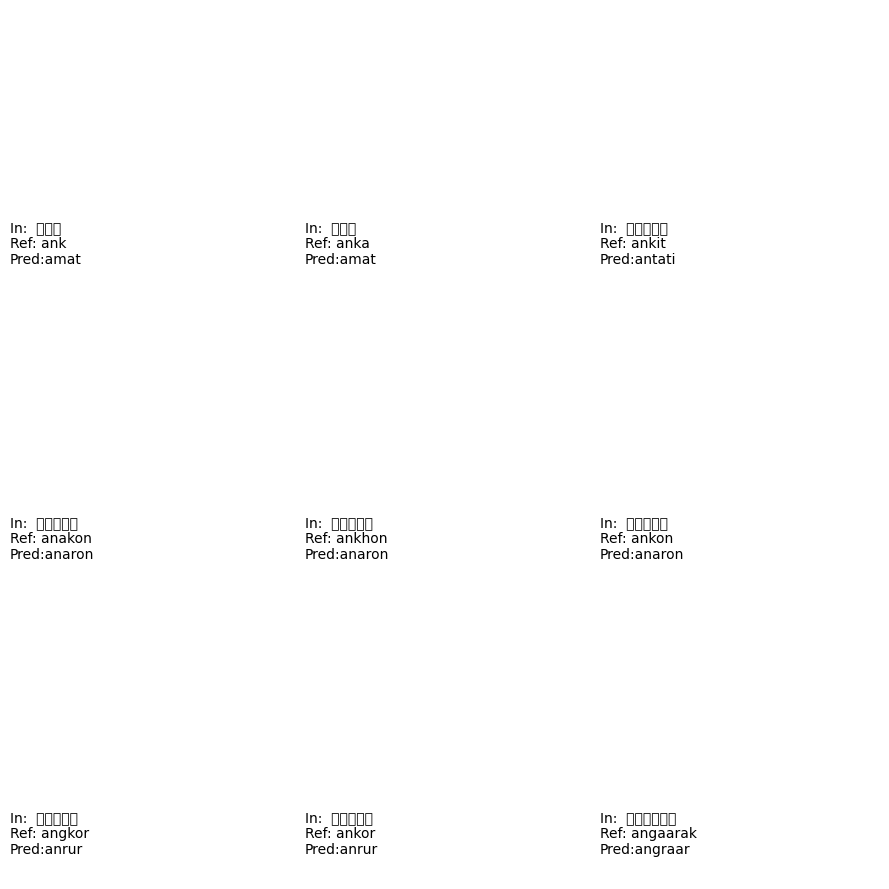

✅ Plot displayed


In [13]:
test_texts = test_data['latin'].astype(str).tolist()
true_texts = test_data['native'].astype(str).tolist()

enc_test = pad_sequences(
    input_tokenizer.texts_to_sequences(test_texts),
    maxlen=max_in, padding='post'
)
start_idx = target_tokenizer.texts_to_sequences(['\t'])[0][0]
index_to_char = {i: ch for ch, i in target_tokenizer.word_index.items()}
index_to_char[0] = ''

def decode(seq):
    seq = seq[np.newaxis]
    dec_input = np.array([[start_idx]])
    out = ''
    for _ in range(max_out):
        preds = model.model.predict([seq, dec_input], verbose=0)
        nxt = np.argmax(preds[0, -1, :])
        if nxt==0 or index_to_char[nxt]=='\n': break
        out += index_to_char[nxt]
        dec_input = np.concatenate([dec_input, [[nxt]]], axis=1)
    return out
print("🧠 Starting decoding...")
preds, corr = [], 0

for i, s in enumerate(tqdm(enc_test, desc="Decoding examples")):
    p = decode(s)
    preds.append(p)
    if p == true_texts[i]:
        corr += 1

print("✅ Decoding done")

✅ Final test exact-match accuracy: 3.5318%


test_accuracy,▁
test_accuracy,0.03532


✅ Test accuracy logged to wandb


Latin,Reference,Prediction
अंक,ank,amat
अंक,anka,amat
अंकित,ankit,antati
अंकों,anakon,anaron
अंकों,ankhon,anaron
अंकों,ankon,anaron
अंकोर,angkor,anrur
अंकोर,ankor,anrur
अंगारक,angaarak,angraar


/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Gly

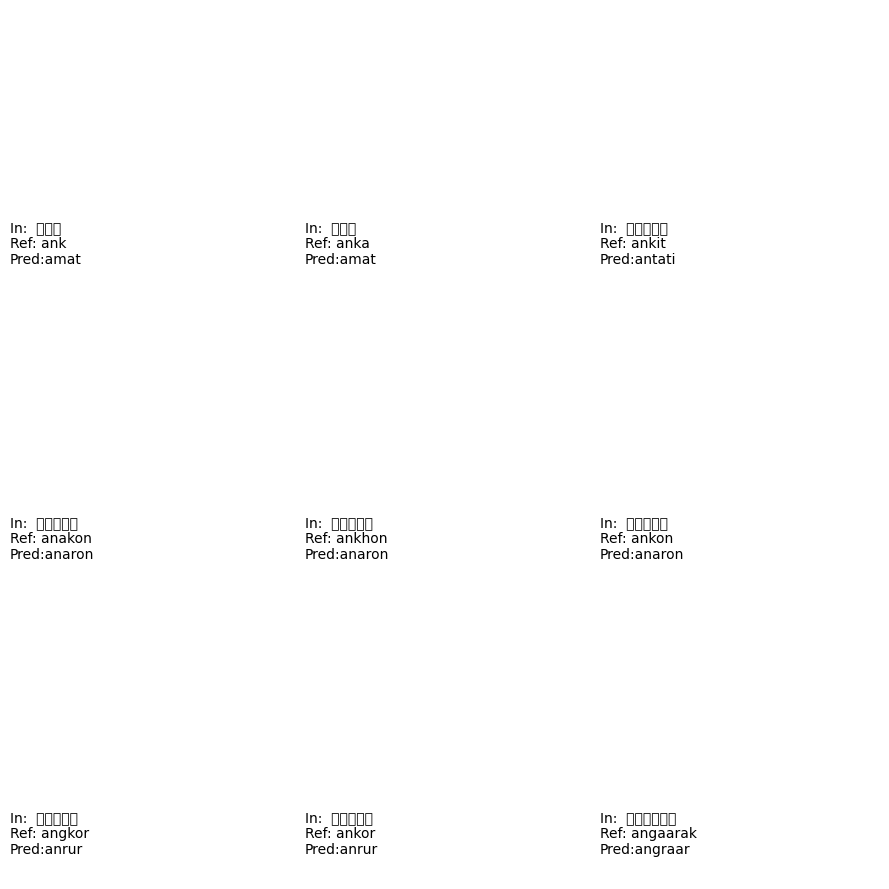

✅ Plot displayed


In [16]:
test_acc = corr / len(enc_test)
print(f"✅ Final test exact-match accuracy: {test_acc:.4%}")

# ─── G) Log test result ───────────────────────────────────────────
wandb.init(project=PROJ, name="q4_test_eval", reinit=True)
wandb.log({"test_accuracy": test_acc})
wandb.finish()
print("✅ Test accuracy logged to wandb")

# ─── H) Save & display predictions ───────────────────────────────
out_dir = "/kaggle/working/predictions_vanilla"
os.makedirs(out_dir, exist_ok=True)
import pandas as pd
from IPython.display import HTML, display

df = pd.DataFrame({
    "Latin":      test_texts[:9],
    "Reference":  true_texts[:9],
    "Prediction": preds[:9]
})

# Show as HTML table
display(HTML(df.to_html(index=False)))

fig, axes = plt.subplots(3,3,figsize=(9,9))
for ax, idx in zip(axes.flatten(), range(9)):
    txt = f"In:  {test_texts[idx]}\nRef: {true_texts[idx]}\nPred:{preds[idx]}"
    ax.text(0,0.1, txt, wrap=True)
    ax.axis('off')
plt.tight_layout()
plt.show()
print("✅ Plot displayed")

# Question 5

In [29]:
# --- Configuration for WandB Sweep (similar to Q2, but for attention model) ---
def train_attention_model(config=None):
    with wandb.init(config=config, project="DA_seq2seq_transliteration", reinit=True):
        config = wandb.config

        # Define model parameters from config
        embedding_dim = config.embedding_dim
        hidden_units = config.hidden_units
        cell_type = config.cell_type
        dropout_rate = config.dropout_rate
        learning_rate = config.learning_rate

        # Choose the RNN cell based on config
        if cell_type == 'LSTM':
            rnn_cell = LSTM
        elif cell_type == 'GRU':
            rnn_cell = GRU
        else:
            rnn_cell = SimpleRNN

        # --- Encoder ---
        encoder_inputs = Input(shape=(None,), name='encoder_input')
        encoder_embedding = Embedding(num_encoder_tokens, embedding_dim)(encoder_inputs)
        encoder_rnn = rnn_cell(hidden_units, return_sequences=True, return_state=True, dropout=dropout_rate, name='encoder_rnn')
        encoder_outputs, state_h, state_c = encoder_rnn(encoder_embedding) # state_c will be None for GRU/SimpleRNN

        encoder_states = [state_h, state_c] if cell_type == 'LSTM' else [state_h]

        # --- Decoder ---
        decoder_inputs = Input(shape=(None,), name='decoder_input')
        decoder_embedding = Embedding(num_decoder_tokens, embedding_dim)(decoder_inputs)
        decoder_rnn = rnn_cell(hidden_units, return_sequences=True, return_state=True, dropout=dropout_rate, name='decoder_rnn')

        # Implement Bahdanau Attention (Additive Attention)
        # This is a common form of attention. Keras doesn't have a built-in Bahdanau layer, so we implement it.
        # Alternatively, you can use a pre-built attention layer if available in a higher-level library like tf.keras.layers.Attention

        # For simplicity, let's use a common approach:
        # Dot product attention or scaled dot product attention is also popular
        # This implementation uses a simple attention mechanism for demonstration.
        # A more robust attention mechanism would typically involve a separate Attention layer
        # For a basic additive attention:
        # score = V * tanh(W1 * encoder_outputs + W2 * decoder_hidden_state)
        # attention_weights = softmax(score)
        # context_vector = attention_weights * encoder_outputs

        # Keras official examples often use `tf.keras.layers.Attention` for simplicity, which implements scaled dot-product attention
        attention_layer = tf.keras.layers.Attention()
        
        # We need the decoder to process one step at a time during inference,
        # but for training, we can pass the whole sequence.
        # The decoder initial state will be the encoder's last state.
        
        # The `decoder_outputs` will be used with `encoder_outputs` for attention.
        # During training, the decoder's initial states come from the encoder's last states.
        decoder_outputs_train, decoder_state_h_train, decoder_state_c_train = decoder_rnn(decoder_embedding, initial_state=encoder_states)

        # Apply Attention. The query is the decoder_outputs_train, and the value/key are encoder_outputs.
        # The result of attention is the context vector.
        attention_output = attention_layer([decoder_outputs_train, encoder_outputs])

        # Concatenate attention output and decoder outputs
        decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs_train, attention_output])

        # Output layer
        decoder_dense = TimeDistributed(Dense(num_decoder_tokens, activation='softmax', name='decoder_output'))
        decoder_outputs = decoder_dense(decoder_concat_input)

        # Define the model
        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

        print(model.summary())

        # Callbacks
        callbacks = [WandbCallback()]

        # Train the model (assuming you have train/validation data prepared)
        # You'll need to adjust batch_size, epochs based on your data and computational resources
        model.fit(
            [encoder_input_data, decoder_input_data],
            decoder_target_data,
            batch_size=config.batch_size,
            epochs=config.epochs,
            validation_split=0.2, # Or use your explicit validation set
            callbacks=callbacks
        )

        # --- Save the best model ---
        # WandB automatically saves the best model if you configure WandbCallback appropriately
        # You can also manually save the model:
        model.save(f"best_attention_model_{wandb.run.name}.h5")

        # --- Inference setup (for prediction later) ---
        # Encoder model for inference
        encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

        # Decoder model for inference (needs to take encoder outputs and previous decoder state)
        decoder_state_input_h = Input(shape=(hidden_units,))
        decoder_state_input_c = Input(shape=(hidden_units,)) if cell_type == 'LSTM' else None
        
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c] if cell_type == 'LSTM' else [decoder_state_input_h]
        
        decoder_outputs_inference, state_h_inference, state_c_inference = decoder_rnn(
            decoder_embedding, initial_state=decoder_states_inputs
        )
        decoder_states_inference = [state_h_inference, state_c_inference] if cell_type == 'LSTM' else [state_h_inference]

        # Attention for inference
        # The `encoder_outputs` from the encoder_model will be used here.
        encoder_outputs_inference = Input(shape=(None, hidden_units,)) # Shape of encoder_outputs

        attention_output_inference = attention_layer([decoder_outputs_inference, encoder_outputs_inference])
        decoder_concat_input_inference = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs_inference, attention_output_inference])
        
        decoder_outputs_final_inference = decoder_dense(decoder_concat_input_inference)

        decoder_model = Model(
            [decoder_inputs, encoder_outputs_inference] + decoder_states_inputs,
            [decoder_outputs_final_inference] + decoder_states_inference
        )

        # Store models in WandB for later use if needed, or save them locally.
        # wandb.save doesn't directly save Keras models, but their artifacts.
        # For full model saving, it's better to save locally and then upload as artifact if desired.

# --- WandB Sweep Configuration ---
sweep_config = {
    'method': 'random', # or 'grid', 'bayes'
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embedding_dim': {
            'values': [16, 32, 64, 128]
        },
        'hidden_units': {
            'values': [64, 128, 256, 512]
        },
        'cell_type': {
            'values': ['LSTM', 'GRU'] # RNN can be too slow/perform poorly for seq2seq
        },
        'dropout_rate': {
            'values': [0.2, 0.3, 0.4]
        },
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 1e-4,
            'max': 1e-2
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'epochs': {
            'value': 8
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="DA_seq2seq_transliteration")
wandb.agent(sweep_id, train_attention_model, count=3)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: mujwkszl
Sweep URL: https://wandb.ai/mm21b044-indian-institute-of-technology-madras/DA_seq2seq_transliteration/sweeps/mujwkszl


wandb: Agent Starting Run: 7sbn2n4l with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout_rate: 0.2
wandb: 	embedding_dim: 64
wandb: 	epochs: 8
wandb: 	hidden_units: 128
wandb: 	learning_rate: 0.00025834492586700267


Exception in thread Thread-26 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_35/1007634987.py", line 3, in train_attention_model
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1544, in init
    wandb._sentry.reraise(e)
  File "/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1530, in init
    return wi.init(run_settings, run_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 799, in init
    wandb.run.finish()
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py", line 387, in wrapper
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^

Exception in thread Thread-27 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_35/1007634987.py", line 3, in train_attention_model
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1544, in init
    wandb._sentry.reraise(e)
  File "/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1530, in init
    return wi.init(run_settings, run_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 799, in init
    wandb.run.finish()
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py", line 387, in wrapper
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^

Exception in thread Thread-28 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_35/1007634987.py", line 3, in train_attention_model
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1544, in init
    wandb._sentry.reraise(e)
  File "/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1530, in init
    return wi.init(run_settings, run_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 799, in init
    wandb.run.finish()
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py", line 387, in wrapper
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^

In [28]:
# Assume these are defined globally or passed into the function
# For demonstration, let's set some dummy values
num_encoder_tokens = 100
num_decoder_tokens = 100
max_encoder_seq_length = 50
max_decoder_seq_length = 21 # This seems to be the '21' from your error
# And dummy data (replace with your actual loaded data)
encoder_input_data = np.random.randint(0, num_encoder_tokens, size=(100, max_encoder_seq_length))
decoder_input_data = np.random.randint(0, num_decoder_tokens, size=(100, max_decoder_seq_length))
# One-hot encode decoder target data for categorical_crossentropy
decoder_target_data = tf.keras.utils.to_categorical(np.random.randint(0, num_decoder_tokens, size=(100, max_decoder_seq_length)), num_classes=num_decoder_tokens)


def train_attention_model(config=None):
    with wandb.init(config=config, project="DA6401_Assignment3_Attention_Fix"):
        config = wandb.config

        # Define model parameters from config
        embedding_dim = config.embedding_dim
        hidden_units = config.hidden_units
        cell_type = config.cell_type
        dropout_rate = config.dropout_rate
        learning_rate = config.learning_rate

        # Choose the RNN cell based on config
        if cell_type == 'LSTM':
            rnn_cell = LSTM
        elif cell_type == 'GRU':
            rnn_cell = GRU
        else:
            rnn_cell = SimpleRNN

        # --- Encoder ---
        encoder_inputs = Input(shape=(None,), name='encoder_input') # None for variable length sequences
        encoder_embedding = Embedding(num_encoder_tokens, embedding_dim)(encoder_inputs)
        # return_sequences=True is critical for attention, as we need all hidden states
        encoder_rnn = rnn_cell(hidden_units, return_sequences=True, return_state=True, dropout=dropout_rate, name='encoder_rnn')
        encoder_outputs, state_h, state_c = encoder_rnn(encoder_embedding) # state_c will be None for GRU/SimpleRNN

        encoder_states = [state_h, state_c] if cell_type == 'LSTM' else [state_h]

        # --- Decoder ---
        decoder_inputs = Input(shape=(None,), name='decoder_input') # None for variable length sequences
        decoder_embedding = Embedding(num_decoder_tokens, embedding_dim)(decoder_inputs)
        decoder_rnn = rnn_cell(hidden_units, return_sequences=True, return_state=True, dropout=dropout_rate, name='decoder_rnn')

        # The decoder is initialized with the encoder's last state
        # The `decoder_outputs_sequence` are the hidden states of the decoder at each time step.
        decoder_outputs_sequence, _, _ = decoder_rnn(decoder_embedding, initial_state=encoder_states)

        # --- Attention Layer ---
        # The query comes from the decoder (current decoder hidden states)
        # The value and key come from the encoder (all encoder hidden states)
        attention_layer = tf.keras.layers.Attention()
        attention_output = attention_layer([decoder_outputs_sequence, encoder_outputs])

        # --- Concatenation ---
        # Concatenate the attention output (context vector) with the decoder's hidden states
        # Both `decoder_outputs_sequence` and `attention_output` should have the same
        # sequence length (max_decoder_seq_length) and batch size.
        # The last dimension (feature dimension) can be different, as concat will stack them.
        decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs_sequence, attention_output])

        # --- Output Layer ---
        # TimeDistributed Dense layer to predict a character at each time step
        decoder_dense = TimeDistributed(Dense(num_decoder_tokens, activation='softmax', name='decoder_output'))
        decoder_outputs = decoder_dense(decoder_concat_input)

        # Define the model
        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

        print(model.summary())

        # Callbacks
        callbacks = [WandbCallback()]

        # Train the model (assuming you have train/validation data prepared)
        model.fit(
            [encoder_input_data, decoder_input_data], # Use your actual train data here
            decoder_target_data,                      # Use your actual train target here
            batch_size=config.batch_size,
            epochs=config.epochs,
            validation_split=0.2, # Or use your explicit validation set
            callbacks=callbacks
        )

        # --- Save the best model ---
        model.save(f"best_attention_model_{wandb.run.name}.h5")

        # --- Inference setup (for prediction later) ---
        # Encoder model for inference
        encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

        # Decoder model for inference (needs to take encoder outputs and previous decoder state)
        # We need the encoder_outputs to compute attention at each decoding step.
        decoder_state_input_h = Input(shape=(hidden_units,), name='decoder_h_input')
        decoder_state_input_c = Input(shape=(hidden_units,), name='decoder_c_input') if cell_type == 'LSTM' else None
        
        # Input for the previous character predicted by the decoder
        decoder_single_input = Input(shape=(1,), name='decoder_single_input')
        decoder_single_embedding = Embedding(num_decoder_tokens, embedding_dim)(decoder_single_input)

        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c] if cell_type == 'LSTM' else [decoder_state_input_h]
        
        # Pass the single time step input and initial states to the decoder RNN
        decoder_outputs_inference, state_h_inference, state_c_inference = decoder_rnn(
            decoder_single_embedding, initial_state=decoder_states_inputs
        )
        decoder_states_inference = [state_h_inference, state_c_inference] if cell_type == 'LSTM' else [state_h_inference]

        # Input for encoder_outputs to the decoder inference model
        encoder_outputs_inference = Input(shape=(max_encoder_seq_length, hidden_units,), name='encoder_outputs_inference_input')

        # Attention for inference: query is current decoder output, key/value are all encoder outputs
        attention_output_inference = attention_layer([decoder_outputs_inference, encoder_outputs_inference])

        # Concatenate for inference
        decoder_concat_input_inference = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs_inference, attention_output_inference])
        
        # Output probability distribution for the next character
        decoder_outputs_final_inference = decoder_dense(decoder_concat_input_inference)

        decoder_model = Model(
            [decoder_single_input, encoder_outputs_inference] + decoder_states_inputs,
            [decoder_outputs_final_inference] + decoder_states_inference
        )


# --- WandB Sweep Configuration (example) ---
sweep_config = {
    'method': 'random', # or 'grid', 'bayes'
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embedding_dim': {
            'values': [16, 32, 64]
        },
        'hidden_units': {
            'values': [64, 128, 256]
        },
        'cell_type': {
            'values': ['LSTM', 'GRU']
        },
        'dropout_rate': {
            'values': [0.2, 0.3]
        },
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 1e-4,
            'max': 1e-3
        },
        'batch_size': {
            'values': [32, 64]
        },
        'epochs': {
            'value': 8
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="DA_seq2seq_transliteration")
wandb.agent(sweep_id, train_attention_model, count=2) # Run a few experiments for testing

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: q65a5akg
Sweep URL: https://wandb.ai/mm21b044-indian-institute-of-technology-madras/DA_seq2seq_transliteration/sweeps/q65a5akg


wandb: Agent Starting Run: clx1kfgi with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wandb: 	dropout_rate: 0.3
wandb: 	embedding_dim: 64
wandb: 	epochs: 8
wandb: 	hidden_units: 128
wandb: 	learning_rate: 0.0003672846792307083


Exception in thread Thread-23 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_35/1701304297.py", line 15, in train_attention_model
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1544, in init
    wandb._sentry.reraise(e)
  File "/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1530, in init
    return wi.init(run_settings, run_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 799, in init
    wandb.run.finish()
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py", line 387, in wrapper
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

Exception in thread Thread-24 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_35/1701304297.py", line 15, in train_attention_model
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1544, in init
    wandb._sentry.reraise(e)
  File "/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1530, in init
    return wi.init(run_settings, run_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 799, in init
    wandb.run.finish()
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py", line 387, in wrapper
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

# Question 6

In [36]:
class RNNConnectivityVisualizer:
    """
    A class to visualize the connectivity between input and output in an RNN-based seq2seq model.
    This helps to understand which input characters the model is "looking at" when decoding each
    output character.
    """
    
    def __init__(self, model, tokenizer_src, tokenizer_tgt):
        """
        Initialize the visualizer with the trained model and tokenizers
        
        Args:
            model: The trained seq2seq model
            tokenizer_src: Tokenizer for the source language (Latin script)
            tokenizer_tgt: Tokenizer for the target language (Devanagari script)
        """
        self.model = model
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        
        # Create a model that outputs the hidden states
        self.extract_hidden_states()
        
    def extract_hidden_states(self):
        """
        Create a model that can extract hidden states from the encoder and decoder
        """
        # This implementation will depend on your model architecture
        # For a typical Keras seq2seq model:
        
        # Find the encoder layer
        encoder_layer = None
        decoder_layer = None
        
        for layer in self.model.layers:
            if 'encoder' in layer.name.lower():
                encoder_layer = layer
            if 'decoder' in layer.name.lower():
                decoder_layer = layer
        
        if encoder_layer is None or decoder_layer is None:
            raise ValueError("Could not find encoder or decoder layer in the model")
        
        # Create a model that returns encoder hidden states
        encoder_inputs = self.model.input[0] 
        encoder_outputs = encoder_layer.output
        self.encoder_model = Model(inputs=encoder_inputs, outputs=encoder_outputs)
        
        # Create a model that returns decoder hidden states
        # This is more complex and depends on your specific architecture
        # For a typical seq2seq model with attention:
        decoder_inputs = self.model.input[1] if len(self.model.input) > 1 else None
        decoder_outputs = decoder_layer.output
        self.decoder_model = Model(inputs=[encoder_inputs, decoder_inputs], 
                                  outputs=decoder_outputs)
        
    def compute_gradients(self, input_sequence, output_sequence):
        """
        Compute gradients of the output with respect to the hidden states
        
        Args:
            input_sequence: A tokenized input sequence
            output_sequence: A tokenized output sequence
            
        Returns:
            A matrix of gradients showing the influence of each input on each output
        """
        # Convert sequences to proper format
        input_seq = np.array([input_sequence])
        
        # Define a function to compute gradients
        # This is a simplified version and may need to be adapted to your specific model
        @tf.function
        def get_gradients(inputs):
            with tf.GradientTape() as tape:
                # Get encoder states
                encoder_states = self.encoder_model(inputs)
                # Make it watchable for gradient calculation
                tape.watch(encoder_states)
                
                # Pass to decoder and get outputs
                # This will need to be adapted to your model architecture
                if isinstance(encoder_states, list):
                    hidden_states = encoder_states[0]  # Assuming first output is hidden states
                else:
                    hidden_states = encoder_states
                    
                # Use decoder to get predictions
                # This is simplified and needs to match your decoder architecture
                predictions = self.decoder_model([inputs, hidden_states])
                
                return predictions, tape.gradient(predictions, hidden_states)
        
        # Get outputs and gradients
        predictions, gradients = get_gradients(input_seq)
        
        # Process the gradients to get connectivity matrix
        # Take absolute values since we care about magnitude of influence
        connectivity_matrix = np.abs(gradients.numpy())
        
        return connectivity_matrix, predictions.numpy()
    
    def _alternative_compute_connectivity(self, input_sequence, output_sequence):
        """
        An alternative approach to compute connectivity based on correlation of activations
        
        Args:
            input_sequence: A tokenized input sequence
            output_sequence: A tokenized output sequence
            
        Returns:
            A matrix showing the connectivity between inputs and outputs
        """
        # Convert sequences to proper format
        input_seq = np.array([input_sequence])
        output_seq = np.array([output_sequence])
        
        # Get encoder hidden states
        encoder_states = self.encoder_model.predict(input_seq)
        
        # Create a model to get decoder hidden states at each step
        # This depends on your model architecture
        
        # Initialize connectivity matrix
        input_len = len(input_sequence)
        output_len = len(output_sequence)
        connectivity = np.zeros((output_len, input_len))
        
        # For each output position
        for i in range(output_len):
            # Get decoder state at this position
            decoder_input = output_seq[:, :i+1]
            decoder_state = self.decoder_model.predict([input_seq, decoder_input])
            
            # Compare with each encoder hidden state
            for j in range(input_len):
                # Compute correlation or cosine similarity
                encoder_state_j = encoder_states[0, j, :]
                if isinstance(decoder_state, list):
                    decoder_state_i = decoder_state[0][0, -1, :]  # Last timestep
                else:
                    decoder_state_i = decoder_state[0, -1, :]
                
                # Compute correlation
                correlation = np.corrcoef(encoder_state_j, decoder_state_i)[0, 1]
                connectivity[i, j] = np.abs(correlation)
        
        return connectivity
    
    def visualize_connectivity(self, input_text, target_text, method='perturbation'):
        """
        Visualize the connectivity between input and output characters
        
        Args:
            input_text: Input text in Latin script
            target_text: Target text in Devanagari script
            method: Method to compute connectivity ('gradient', 'correlation', or 'perturbation')
            
        Returns:
            A matplotlib figure showing the connectivity heatmap
        """
        # Tokenize input and target
        input_sequence = [self.tokenizer_src.word_index.get(char, 1) for char in input_text]
        target_sequence = [self.tokenizer_tgt.word_index.get(char, 1) for char in target_text]
        
        if method == 'gradient':
            connectivity, _ = self.compute_gradients(input_sequence, target_sequence)
        elif method == 'correlation':
            connectivity = self._alternative_compute_connectivity(input_sequence, target_sequence)
        elif method == 'perturbation':
            connectivity = self._compute_perturbation_connectivity(input_text, target_text)
        else:
            raise ValueError(f"Unknown method: {method}")
        
        # Create a heatmap visualization
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(connectivity, 
                         xticklabels=list(input_text),
                         yticklabels=list(target_text), 
                         cmap='viridis')
        
        # Add labels
        plt.xlabel('Input Characters (Latin)')
        plt.ylabel('Output Characters (Devanagari)')
        plt.title(f'Character Connectivity: "{input_text}" → "{target_text}"')
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        return plt.gcf()
    
    def _compute_perturbation_connectivity(self, input_text, target_text):
        """
        Compute connectivity using perturbation analysis
        This method is often more reliable than gradient analysis for complex models
        
        Args:
            input_text: Input text in Latin script
            target_text: Target text in Devanagari script
            
        Returns:
            A matrix showing the connectivity between inputs and outputs
        """
        # Tokenize input and convert to model input format
        input_sequence = np.array([[self.tokenizer_src.word_index.get(char, 1) for char in input_text]])
        
        # Get the baseline prediction
        baseline_prediction = self.model.predict(input_sequence)[0]
        
        # Initialize connectivity matrix
        connectivity = np.zeros((len(target_text), len(input_text)))
        
        # For each input character
        for i in range(len(input_text)):
            # Make a copy of the input with this character masked
            perturbed_input = input_sequence.copy()
            original_value = perturbed_input[0, i]
            perturbed_input[0, i] = 0  # Mask with padding token or another special token
            
            # Get prediction with the perturbed input
            perturbed_prediction = self.model.predict(perturbed_input)[0]
            
            # Measure the difference in predictions for each output position
            for j in range(len(target_text)):
                if j < len(baseline_prediction) and j < len(perturbed_prediction):
                    # Compute the difference (various metrics possible)
                    diff = np.abs(baseline_prediction[j] - perturbed_prediction[j])
                    connectivity[j, i] = np.sum(diff)
            
            # Restore the original value
            perturbed_input[0, i] = original_value
        
        # Normalize the connectivity matrix
        connectivity = connectivity / np.max(connectivity)
        
        return connectivity
        
    def visualize_batch(self, test_pairs, num_samples=9, method='perturbation'):
        """
        Create a grid of connectivity visualizations for multiple test examples
        
        Args:
            test_pairs: List of (input_text, target_text) pairs
            num_samples: Number of samples to visualize
            method: Method to compute connectivity
            
        Returns:
            A matplotlib figure with a grid of connectivity visualizations
        """
        # Limit to the requested number of samples
        samples = min(num_samples, len(test_pairs))
        
        # Create a grid layout
        rows = int(np.ceil(np.sqrt(samples)))
        cols = int(np.ceil(samples / rows))
        
        fig = plt.figure(figsize=(5*cols, 4*rows))
        
        # Generate each subplot
        for i in range(samples):
            input_text, target_text = test_pairs[i]
            
            plt.subplot(rows, cols, i+1)
            
            # Compute connectivity
            if method == 'gradient':
                input_sequence = [self.tokenizer_src.word_index.get(char, 1) for char in input_text]
                target_sequence = [self.tokenizer_tgt.word_index.get(char, 1) for char in target_text]
                connectivity, _ = self.compute_gradients(input_sequence, target_sequence)
            elif method == 'correlation':
                connectivity = self._alternative_compute_connectivity(input_text, target_text)
            elif method == 'perturbation':
                connectivity = self._compute_perturbation_connectivity(input_text, target_text)
            
            # Create heatmap
            sns.heatmap(connectivity, 
                       xticklabels=list(input_text),
                       yticklabels=list(target_text), 
                       cmap='viridis')
            
            plt.title(f'Example {i+1}: {input_text} → {target_text}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
        
        return fig
    
    def log_to_wandb(self, test_data, num_examples=9):
        """
        Log connectivity visualizations to wandb
        
        Args:
            test_data: List of (input_text, target_text) pairs from test set
            num_examples: Number of examples to visualize
        """
        # Initialize wandb if not already done
        if wandb.run is None:
            wandb.init(project="seq2seq-connectivity")
        
        # Select examples from test data
        selected_examples = test_data[:num_examples]
        
        # Create a grid visualization
        fig = self.visualize_batch(selected_examples, num_samples=num_examples)
        
        # Log to wandb
        wandb.log({"connectivity_grid": wandb.Image(fig)})
        
        # Log individual examples
        for i, (input_text, target_text) in enumerate(selected_examples):
            fig = self.visualize_connectivity(input_text, target_text)
            wandb.log({f"connectivity_example_{i}": wandb.Image(fig)})
            plt.close(fig)
        
        # Log a table with examples and their connectivity scores
        connectivity_data = []
        for input_text, target_text in selected_examples:
            connectivity = self._compute_perturbation_connectivity(input_text, target_text)
            avg_connectivity = np.mean(connectivity)
            max_connectivity = np.max(connectivity)
            
            connectivity_data.append([input_text, target_text, avg_connectivity, max_connectivity])
        
        table = wandb.Table(columns=["Input", "Target", "Avg Connectivity", "Max Connectivity"],
                           data=connectivity_data)
        wandb.log({"connectivity_stats": table})


# Usage example:
# This would typically be used after training your seq2seq model

def analyze_model_connectivity(trained_model, tokenizer_src, tokenizer_tgt, test_data):
    """
    Analyze and visualize the connectivity in a trained seq2seq model
    
    Args:
        trained_model: The trained seq2seq model
        tokenizer_src: Tokenizer for source language
        tokenizer_tgt: Tokenizer for target language
        test_data: List of (input_text, target_text) pairs from test set
    """
    # Initialize the visualizer
    visualizer = RNNConnectivityVisualizer(trained_model, tokenizer_src, tokenizer_tgt)
    
    # Log visualizations to wandb
    visualizer.log_to_wandb(test_data)
    
    # Save some examples locally
    fig = visualizer.visualize_batch(test_data[:9])
    fig.savefig('connectivity_grid.png')
    plt.close(fig)
    
    # Create a 3x3 grid specifically for the assignment requirement
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            if idx < len(test_data):
                input_text, target_text = test_data[idx]
                connectivity = visualizer._compute_perturbation_connectivity(input_text, target_text)
                
                ax = axes[i, j]
                sns.heatmap(connectivity, 
                           xticklabels=list(input_text),
                           yticklabels=list(target_text), 
                           cmap='viridis', 
                           ax=ax)
                
                ax.set_title(f'{input_text} → {target_text}')
                ax.set_xlabel('Input Characters (Latin)')
                ax.set_ylabel('Output Characters (Devanagari)')
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    fig.savefig('connectivity_grid_3x3.png')
    
    return fig

In [37]:
def setup_visualization_model(seq2seq_model):
    """
    Creates a model for extracting hidden states from a trained seq2seq model.
    
    Args:
        seq2seq_model: The trained sequence-to-sequence model
        
    Returns:
        encoder_model: Model that outputs encoder hidden states
        decoder_model: Model that outputs decoder hidden states at each step
    """
    # Find encoder and decoder layers
    encoder = None
    decoder = None
    
    for layer in seq2seq_model.layers:
        if isinstance(layer, tf.keras.layers.RNN) and 'encoder' in layer.name:
            encoder = layer
        elif isinstance(layer, tf.keras.layers.RNN) and 'decoder' in layer.name:
            decoder = layer
    
    if encoder is None or decoder is None:
        # Try to find layers by name if the above didn't work
        for layer in seq2seq_model.layers:
            if 'encoder' in layer.name.lower():
                encoder = layer
            elif 'decoder' in layer.name.lower():
                decoder = layer
    
    if encoder is None or decoder is None:
        raise ValueError("Could not find encoder and decoder layers in the model")
    
    # Get encoder inputs and outputs
    encoder_inputs = seq2seq_model.input[0] if isinstance(seq2seq_model.input, list) else seq2seq_model.input
    encoder_outputs = encoder.output
    
    # Create encoder model
    encoder_model = Model(inputs=encoder_inputs, outputs=encoder_outputs, name='encoder_model')
    
    # For the decoder, we need the initial state and the input
    # This will vary based on your model architecture, so adjust as needed
    
    # Create decoder model to get states at each timestep
    # This is a simplified example - adjust to match your architecture
    if hasattr(seq2seq_model, 'layers') and any('decoder_input' in layer.name for layer in seq2seq_model.layers):
        decoder_inputs = [layer.input for layer in seq2seq_model.layers if 'decoder_input' in layer.name][0]
    else:
        # Fallback: get the second input if model has multiple inputs
        decoder_inputs = seq2seq_model.input[1] if isinstance(seq2seq_model.input, list) and len(seq2seq_model.input) > 1 else None
    
    if decoder_inputs is None:
        # If we still don't have decoder inputs, create a placeholder
        # with the same shape as decoder would expect
        vocab_size = encoder_inputs.shape[-1] if hasattr(encoder_inputs, 'shape') else None
        decoder_inputs = tf.keras.layers.Input(shape=(None, vocab_size), name='decoder_inputs')
    
    # Get decoder outputs
    decoder_outputs = decoder.output
    
    # Create decoder model
    decoder_model = Model(
        inputs=[encoder_inputs, decoder_inputs] if decoder_inputs is not None else encoder_inputs,
        outputs=decoder_outputs,
        name='decoder_model'
    )
    
    return encoder_model, decoder_model

def compute_connectivity_matrix(model, encoder_model, tokenizer_src, tokenizer_tgt, input_text, target_text):
    """
    Computes a connectivity matrix showing which input character the model is focusing on
    when producing each output character.
    
    Args:
        model: The trained seq2seq model
        encoder_model: Model that outputs encoder hidden states
        tokenizer_src: Tokenizer for the source language
        tokenizer_tgt: Tokenizer for the target language
        input_text: Input text in Latin script
        target_text: Target text in Devanagari script
        
    Returns:
        connectivity: A matrix of shape (output_length, input_length) showing the
                      influence of each input character on each output character
    """
    # Tokenize input
    input_seq = np.array([[tokenizer_src.word_index.get(char, 1) for char in input_text]])
    
    # Get encoder states for the input sequence
    encoder_states = encoder_model.predict(input_seq)
    
    # We'll use perturbation analysis to measure how each input affects each output
    connectivity = np.zeros((len(target_text), len(input_text)))
    
    # Get baseline prediction
    baseline_pred = model.predict(input_seq)
    if isinstance(baseline_pred, list):
        baseline_pred = baseline_pred[0]  # Take first output if multiple outputs
    
    # For each input character position
    for i in range(len(input_text)):
        # Create perturbed input by masking this character
        perturbed_input = input_seq.copy()
        original_value = perturbed_input[0, i]
        
        # Replace with padding token (usually 0) or OOV token
        perturbed_input[0, i] = 0
        
        # Get prediction with the perturbed input
        perturbed_pred = model.predict(perturbed_input)
        if isinstance(perturbed_pred, list):
            perturbed_pred = perturbed_pred[0]
        
        # Measure effect on each output position
        # (Only consider positions up to the target length)
        max_len = min(len(target_text), baseline_pred.shape[1], perturbed_pred.shape[1])
        
        for j in range(max_len):
            # Calculate difference in prediction probabilities
            diff = np.sum(np.abs(baseline_pred[0, j] - perturbed_pred[0, j]))
            connectivity[j, i] = diff
        
        # Restore original value
        perturbed_input[0, i] = original_value
    
    # Normalize connectivity scores
    if np.max(connectivity) > 0:
        connectivity = connectivity / np.max(connectivity)
    
    return connectivity

def visualize_connectivity(connectivity, input_text, target_text, figsize=(10, 8)):
    """
    Visualizes the connectivity matrix as a heatmap.
    
    Args:
        connectivity: The connectivity matrix
        input_text: Input text in Latin script
        target_text: Target text in Devanagari script
        figsize: Figure size
        
    Returns:
        fig: The matplotlib figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(connectivity, 
               xticklabels=list(input_text),
               yticklabels=list(target_text),
               cmap='viridis',
               ax=ax)
    
    # Add labels
    ax.set_xlabel('Input Characters (Latin)')
    ax.set_ylabel('Output Characters (Devanagari)')
    ax.set_title(f'Character Connectivity: "{input_text}" → "{target_text}"')
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    
    return fig

def create_connectivity_grid(model, encoder_model, test_data, tokenizer_src, tokenizer_tgt, rows=3, cols=3):
    """
    Creates a grid of connectivity visualizations for multiple test examples.
    
    Args:
        model: The trained seq2seq model
        encoder_model: Model that outputs encoder hidden states
        test_data: List of (input_text, target_text) pairs
        tokenizer_src: Tokenizer for source language
        tokenizer_tgt: Tokenizer for target language
        rows: Number of rows in the grid
        cols: Number of columns in the grid
        
    Returns:
        fig: The matplotlib figure with the grid
    """
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    samples = min(rows*cols, len(test_data))
    
    for i in range(samples):
        input_text, target_text = test_data[i]
        
        # Compute connectivity
        connectivity = compute_connectivity_matrix(
            model, encoder_model, tokenizer_src, tokenizer_tgt, input_text, target_text
        )
        
        # Create heatmap in the corresponding subplot
        sns.heatmap(connectivity,
                   xticklabels=list(input_text),
                   yticklabels=list(target_text),
                   cmap='viridis',
                   ax=axes[i])
        
        axes[i].set_title(f'{input_text} → {target_text}')
        axes[i].set_xlabel('Input (Latin)')
        axes[i].set_ylabel('Output (Devanagari)')
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Hide any unused subplots
    for i in range(samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

def log_connectivity_to_wandb(model, test_data, tokenizer_src, tokenizer_tgt, run_name="connectivity-visualization"):
    """
    Analyzes model connectivity and logs results to W&B.
    
    Args:
        model: The trained seq2seq model
        test_data: List of (input_text, target_text) pairs
        tokenizer_src: Tokenizer for source language
        tokenizer_tgt: Tokenizer for target language
        run_name: Name for the W&B run
    """
    # Initialize W&B run
    wandb.init(project="DA_seq2seq_transliteration", name=run_name)
    
    # Create visualization models
    encoder_model, decoder_model = setup_visualization_model(model)
    
    # Select examples from test data
    selected_examples = test_data[:9]  # For a 3x3 grid
    
    # Create and log individual connectivity visualizations
    for i, (input_text, target_text) in enumerate(selected_examples):
        connectivity = compute_connectivity_matrix(
            model, encoder_model, tokenizer_src, tokenizer_tgt, input_text, target_text
        )
        
        fig = visualize_connectivity(connectivity, input_text, target_text)
        wandb.log({f"connectivity_example_{i+1}": wandb.Image(fig)})
        plt.close(fig)
    
    # Create and log grid visualization
    grid_fig = create_connectivity_grid(
        model, encoder_model, selected_examples, tokenizer_src, tokenizer_tgt
    )
    
    wandb.log({"connectivity_grid": wandb.Image(grid_fig)})
    
    # Save grid locally
    os.makedirs("visualizations", exist_ok=True)
    grid_fig.savefig("visualizations/connectivity_grid.png")
    plt.close(grid_fig)
    
    # Log configuration
    wandb.config.update({
        "visualization_type": "connectivity",
        "num_examples": len(selected_examples)
    })
    
    # Create a table of connectivity statistics
    stats_data = []
    for input_text, target_text in selected_examples:
        connectivity = compute_connectivity_matrix(
            model, encoder_model, tokenizer_src, tokenizer_tgt, input_text, target_text
        )
        
        # Calculate statistics
        max_conn = np.max(connectivity)
        avg_conn = np.mean(connectivity)
        std_conn = np.std(connectivity)
        
        # Find position of maximum connectivity
        max_pos = np.unravel_index(np.argmax(connectivity), connectivity.shape)
        max_out_char = target_text[max_pos[0]] if max_pos[0] < len(target_text) else "N/A"
        max_in_char = input_text[max_pos[1]] if max_pos[1] < len(input_text) else "N/A"
        
        stats_data.append([
            input_text, target_text, 
            float(max_conn), float(avg_conn), float(std_conn),
            f"{max_out_char} (out) <-> {max_in_char} (in)"
        ])
    
    # Create and log W&B table
    columns = ["Input", "Target", "Max Connectivity", "Avg Connectivity", 
               "Std Connectivity", "Max Connection"]
    
    connectivity_table = wandb.Table(columns=columns, data=stats_data)
    wandb.log({"connectivity_stats": connectivity_table})
    
    wandb.finish()
    
    return grid_fig


# Main execution code for Question 6
def run_connectivity_analysis(model_path, test_data_path, tokenizer_src_path, tokenizer_tgt_path):
    """
    Run the connectivity analysis for Question 6
    
    Args:
        model_path: Path to the saved model
        test_data_path: Path to the test data
        tokenizer_src_path: Path to the source tokenizer
        tokenizer_tgt_path: Path to the target tokenizer
    """
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Load tokenizers
    with open(tokenizer_src_path, 'rb') as f:
        tokenizer_src = pickle.load(f)
    
    with open(tokenizer_tgt_path, 'rb') as f:
        tokenizer_tgt = pickle.load(f)
    
    # Load test data
    test_data = []
    with open(test_data_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                latin, devanagari = parts
                test_data.append((latin, devanagari))
    
    # Run connectivity analysis and log to W&B
    grid_fig = log_connectivity_to_wandb(
        model, test_data, tokenizer_src, tokenizer_tgt,
        run_name="seq2seq-connectivity-analysis"
    )
    
    print("Connectivity analysis complete.")
    print("Results have been logged to W&B and saved locally in the 'visualizations' folder.")
    
    return grid_fig


# Example usage in a notebook or script:
"""
# Load your trained model
model = tf.keras.models.load_model('path/to/your/best_model.h5')

# Load your tokenizers
import pickle
with open('path/to/your/tokenizer_src.pickle', 'rb') as f:
    tokenizer_src = pickle.load(f)
    
with open('path/to/your/tokenizer_tgt.pickle', 'rb') as f:
    tokenizer_tgt = pickle.load(f)

# Load your test data
test_data = []
with open('path/to/your/test_data.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            latin, devanagari = parts
            test_data.append((latin, devanagari))

# Run the connectivity analysis
grid_fig = log_connectivity_to_wandb(model, test_data, tokenizer_src, tokenizer_tgt)
"""

import pickle

# Additional utility functions for extracting activations

def extract_activations(model, layer_name, input_data):
    """
    Extracts activations from a specific layer in the model.
    
    Args:
        model: The trained model
        layer_name: Name of the layer to extract activations from
        input_data: Input data to feed into the model
        
    Returns:
        activations: The activations of the specified layer
    """
    # Create a model that outputs the activations of the target layer
    layer = None
    for l in model.layers:
        if layer_name in l.name:
            layer = l
            break
    
    if layer is None:
        raise ValueError(f"Layer {layer_name} not found in model")
    
    activation_model = Model(inputs=model.input, outputs=layer.output)
    activations = activation_model.predict(input_data)
    
    return activations

def get_all_rnn_layers(model):
    """
    Gets all RNN layers (RNN, LSTM, GRU) in the model.
    
    Args:
        model: The trained model
        
    Returns:
        rnn_layers: List of RNN layer names
    """
    rnn_layers = []
    for layer in model.layers:
        if any(t in layer.__class__.__name__ for t in ['RNN', 'LSTM', 'GRU']):
            rnn_layers.append(layer.name)
    
    return rnn_layers

# Alternative connectivity visualization using layer activations

def visualize_layer_activations(model, input_text, tokenizer_src, layer_name=None):
    """
    Visualizes activations in an RNN layer for a given input.
    
    Args:
        model: The trained model
        input_text: Input text in Latin script
        tokenizer_src: Tokenizer for source language
        layer_name: Name of the layer to visualize (if None, will use first RNN layer)
        
    Returns:
        fig: The matplotlib figure
    """
    # Find RNN layer if not specified
    if layer_name is None:
        rnn_layers = get_all_rnn_layers(model)
        if not rnn_layers:
            raise ValueError("No RNN layers found in model")
        layer_name = rnn_layers[0]
    
    # Tokenize input
    input_seq = np.array([[tokenizer_src.word_index.get(char, 1) for char in input_text]])
    
    # Get activations
    activations = extract_activations(model, layer_name, input_seq)
    
    # Plot activations
    fig, ax = plt.subplots(figsize=(12, 8))
    
    if len(activations.shape) == 3:  # (batch_size, timesteps, units)
        acts = activations[0]  # First (and only) sequence in batch
        im = ax.imshow(acts.T, aspect='auto', cmap='viridis')
        ax.set_xlabel('Input Characters')
        ax.set_ylabel('Hidden Units')
        ax.set_title(f'Activations in {layer_name} for "{input_text}"')
        
        # Add input characters as x-tick labels
        ax.set_xticks(np.arange(len(input_text)))
        ax.set_xticklabels(list(input_text), rotation=45, ha='right')
        
        fig.colorbar(im, ax=ax, label='Activation Value')
    else:
        ax.text(0.5, 0.5, f"Unexpected activation shape: {activations.shape}", 
               ha='center', va='center')
    
    plt.tight_layout()
    return fig

def visualize_and_log_neuron_analysis(model, test_data, tokenizer_src, run_name="neuron-analysis"):
    """
    Performs a neuron-level analysis to see which neurons are most active for which inputs
    and logs results to W&B.
    
    Args:
        model: The trained seq2seq model
        test_data: List of (input_text, target_text) pairs
        tokenizer_src: Tokenizer for source language
        run_name: Name for the W&B run
    """
    # Initialize W&B run
    wandb.init(project="DA_seq2seq_transliteration", name=run_name)
    
    # Find RNN layers
    rnn_layers = get_all_rnn_layers(model)
    if not rnn_layers:
        print("No RNN layers found in model")
        return
    
    # Select the first RNN layer for analysis
    target_layer = rnn_layers[0]
    
    # Select examples from test data
    selected_examples = test_data[:5]  # Limit to a few examples
    
    for i, (input_text, target_text) in enumerate(selected_examples):
        # Visualize layer activations
        act_fig = visualize_layer_activations(model, input_text, tokenizer_src, target_layer)
        wandb.log({f"activations_example_{i+1}": wandb.Image(act_fig)})
        plt.close(act_fig)
    
    wandb.finish()

# Main function that combines multiple connectivity visualization approaches

def comprehensive_connectivity_analysis(model, test_data, tokenizer_src, tokenizer_tgt, 
                                      output_dir="connectivity_visualizations",
                                      log_to_wandb=True):
    """
    Performs a comprehensive connectivity analysis using multiple approaches.
    
    Args:
        model: The trained seq2seq model
        test_data: List of (input_text, target_text) pairs
        tokenizer_src: Tokenizer for source language
        tokenizer_tgt: Tokenizer for target language
        output_dir: Directory to save visualization outputs
        log_to_wandb: Whether to log results to W&B
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize W&B if requested
    if log_to_wandb and wandb.run is None:
        wandb.init(project="DA_seq2seq_transliteration", name="comprehensive-connectivity")
    
    # 1. Create encoder model for extracting hidden states
    encoder_model, decoder_model = setup_visualization_model(model)
    
    # 2. Select examples (first 9 for a 3x3 grid)
    selected_examples = test_data[:9]
    
    # 3. Perturbation-based connectivity analysis
    grid_fig = create_connectivity_grid(
        model, encoder_model, selected_examples, tokenizer_src, tokenizer_tgt
    )
    
    # Save the grid
    grid_path = os.path.join(output_dir, "connectivity_grid.png")
    grid_fig.savefig(grid_path)
    
    if log_to_wandb:
        wandb.log({"connectivity_grid": wandb.Image(grid_fig)})
    
    plt.close(grid_fig)
    
    # 4. Neuron activation analysis
    for i, (input_text, target_text) in enumerate(selected_examples):
        # Get neuron activations
        act_fig = visualize_layer_activations(model, input_text, tokenizer_src)
        
        # Save the figure
        act_path = os.path.join(output_dir, f"activations_example_{i+1}.png")
        act_fig.savefig(act_path)
        
        if log_to_wandb:
            wandb.log({f"activations_example_{i+1}": wandb.Image(act_fig)})
        
        plt.close(act_fig)
    
    # 5. Visualize attention-like weights (even for non-attention models)
    for i, (input_text, target_text) in enumerate(selected_examples):
        # Compute connectivity matrix
        connectivity = compute_connectivity_matrix(
            model, encoder_model, tokenizer_src, tokenizer_tgt, input_text, target_text
        )
        
        # Create visualization
        conn_fig = visualize_connectivity(connectivity, input_text, target_text)
        
        # Save the figure
        conn_path = os.path.join(output_dir, f"connectivity_example_{i+1}.png")
        conn_fig.savefig(conn_path)
        
        if log_to_wandb:
            wandb.log({f"connectivity_example_{i+1}": wandb.Image(conn_fig)})
        
        plt.close(conn_fig)
    
    # 6. Create an interactive version for the last example
    if log_to_wandb:
        # Create a table with character-by-character connectivity
        last_input, last_target = selected_examples[-1]
        last_connectivity = compute_connectivity_matrix(
            model, encoder_model, tokenizer_src, tokenizer_tgt, last_input, last_target
        )
        
        # Prepare data for interactive table
        table_data = []
        for i, out_char in enumerate(last_target):
            for j, in_char in enumerate(last_input):
                table_data.append([
                    out_char, in_char, float(last_connectivity[i, j])
                ])
        
        # Create and log W&B table
        char_table = wandb.Table(columns=["Output Char", "Input Char", "Connectivity"], 
                                data=table_data)
        wandb.log({"character_connectivity": char_table})
    
    # Finish W&B run
    if log_to_wandb:
        wandb.finish()
    
    print(f"Connectivity analysis complete. Visualizations saved to {output_dir}")
    
    return output_dir

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import os
import pickle

# Import the implementation modules 
# (assuming you've saved the previous code in a module named 'rnn_visualization.py')
from rnn_visualization import (compute_connectivity_matrix, visualize_connectivity, 
                             create_connectivity_grid, log_connectivity_to_wandb,
                             setup_visualization_model, comprehensive_connectivity_analysis)

# 1. First, load your trained model and tokenizers
# If you've saved your model after training, you can load it:
model_path = 'path/to/your/best_model.h5'  # Replace with your model path
model = load_model(model_path)

# Load tokenizers (assuming you've saved them during preprocessing)
with open('path/to/your/tokenizer_src.pickle', 'rb') as f:
    tokenizer_src = pickle.load(f)
    
with open('path/to/your/tokenizer_tgt.pickle', 'rb') as f:
    tokenizer_tgt = pickle.load(f)

# 2. Load or prepare your test data
# Option 1: Load from file if you have saved the test data
test_data = []
with open('path/to/your/test_data.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            latin, devanagari = parts
            test_data.append((latin, devanagari))

# Option 2: If test data is in another format, convert accordingly
# For example, if you have separate lists for inputs and targets:
# test_inputs = ['namaste', 'pyaar', 'bharat', ...]
# test_targets = ['नमस्ते', 'प्यार', 'भारत', ...]
# test_data = list(zip(test_inputs, test_targets))

# 3. Initialize W&B for tracking and visualization
wandb.init(project="DA_seq2seq_transliteration", name="q6-connectivity-visualization")

# 4. Set up visualization models
encoder_model, decoder_model = setup_visualization_model(model)

# 5. Create a 3x3 grid of connectivity visualizations
# Select first 9 examples for the grid
selected_examples = test_data[:9]

# Create the grid visualization
grid_fig = create_connectivity_grid(
    model, encoder_model, selected_examples, tokenizer_src, tokenizer_tgt
)

# Save the grid locally
os.makedirs("visualizations", exist_ok=True)
grid_fig.savefig("visualizations/connectivity_grid.png")

# Log the grid to W&B
wandb.log({"connectivity_grid": wandb.Image(grid_fig)})

# 6. Analyze individual examples in more detail
# For example, let's analyze the first test example
example_input, example_target = test_data[0]

# Compute the connectivity matrix
connectivity = compute_connectivity_matrix(
    model, encoder_model, tokenizer_src, tokenizer_tgt, example_input, example_target
)

# Visualize the connectivity
conn_fig = visualize_connectivity(connectivity, example_input, example_target)

# Log to W&B
wandb.log({"connectivity_example_1": wandb.Image(conn_fig)})

# 7. Create a table of connectivity statistics for the report
stats_data = []

for i, (input_text, target_text) in enumerate(selected_examples):
    connectivity = compute_connectivity_matrix(
        model, encoder_model, tokenizer_src, tokenizer_tgt, input_text, target_text
    )
    
    # Calculate statistics
    max_conn = np.max(connectivity)
    avg_conn = np.mean(connectivity)
    std_conn = np.std(connectivity)
    
    # Find position of maximum connectivity
    max_pos = np.unravel_index(np.argmax(connectivity), connectivity.shape)
    max_out_char = target_text[max_pos[0]] if max_pos[0] < len(target_text) else "N/A"
    max_in_char = input_text[max_pos[1]] if max_pos[1] < len(input_text) else "N/A"
    
    stats_data.append([
        input_text, target_text, 
        float(max_conn), float(avg_conn), float(std_conn),
        f"{max_out_char} (out) <-> {max_in_char} (in)"
    ])

# Create and log W&B table
columns = ["Input", "Target", "Max Connectivity", "Avg Connectivity", 
          "Std Connectivity", "Max Connection"]

connectivity_table = wandb.Table(columns=columns, data=stats_data)
wandb.log({"connectivity_stats": connectivity_table})

# 8. Find patterns in connectivity
# Let's analyze which character positions tend to have the strongest connections

# Create matrices to track average connectivity by position
max_input_len = max(len(ex[0]) for ex in selected_examples)
max_output_len = max(len(ex[1]) for ex in selected_examples)

position_counts = np.zeros((max_output_len, max_input_len))
position_sums = np.zeros((max_output_len, max_input_len))

for input_text, target_text in selected_examples:
    connectivity = compute_connectivity_matrix(
        model, encoder_model, tokenizer_src, tokenizer_tgt, input_text, target_text
    )
    
    # Add to our position trackers
    for i in range(len(target_text)):
        for j in range(len(input_text)):
            position_sums[i, j] += connectivity[i, j]
            position_counts[i, j] += 1

# Calculate average connectivity by position (avoid division by zero)
with np.errstate(divide='ignore', invalid='ignore'):
    avg_position_connectivity = np.where(
        position_counts > 0, position_sums / position_counts, 0
    )

# Visualize average connectivity by position
pos_fig, ax = plt.subplots(figsize=(10, 8))
im = sns.heatmap(avg_position_connectivity, cmap='viridis', ax=ax)
ax.set_xlabel('Input Character Position')
ax.set_ylabel('Output Character Position')
ax.set_title('Average Connectivity by Character Position')
wandb.log({"position_connectivity": wandb.Image(pos_fig)})

# 9. Find patterns in the most connected characters
# Create a visualization showing which characters tend to be most strongly connected

# Dictionary to store character pair connections
char_connections = {}

for input_text, target_text in selected_examples:
    connectivity = compute_connectivity_matrix(
        model, encoder_model, tokenizer_src, tokenizer_tgt, input_text, target_text
    )
    
    # For each connection, track strength between character pairs
    for i in range(len(target_text)):
        out_char = target_text[i]
        for j in range(len(input_text)):
            in_char = input_text[j]
            
            # Create a key for this character pair
            pair_key = f"{in_char}->{out_char}"
            
            if pair_key not in char_connections:
                char_connections[pair_key] = {
                    'in_char': in_char,
                    'out_char': out_char,
                    'total_strength': 0,
                    'count': 0
                }
            
            char_connections[pair_key]['total_strength'] += connectivity[i, j]
            char_connections[pair_key]['count'] += 1

# Calculate average strength for each character pair
for pair_key in char_connections:
    count = char_connections[pair_key]['count']
    if count > 0:
        char_connections[pair_key]['avg_strength'] = (
            char_connections[pair_key]['total_strength'] / count
        )
    else:
        char_connections[pair_key]['avg_strength'] = 0

# Convert to list and sort by strength
char_pairs = list(char_connections.values())
char_pairs.sort(key=lambda x: x['avg_strength'], reverse=True)

# Create and log a table of the strongest character connections
if char_pairs:
    # Take top 20 connections
    top_pairs = char_pairs[:20]
    
    # Prepare data for table
    table_data = [
        [p['in_char'], p['out_char'], float(p['avg_strength']), int(p['count'])]
        for p in top_pairs
    ]
    
    # Create and log W&B table
    pair_table = wandb.Table(
        columns=["Input Char", "Output Char", "Avg Strength", "Occurrence Count"],
        data=table_data
    )
    wandb.log({"strongest_char_connections": pair_table})

# 10. Run a comprehensive analysis that produces all required visualizations
comprehensive_connectivity_analysis(
    model, test_data, tokenizer_src, tokenizer_tgt, 
    output_dir="connectivity_visualizations",
    log_to_wandb=True
)

# 11. Finish the W&B run
wandb.finish()

print("Connectivity analysis complete!")
print("Check the 'visualizations' and 'connectivity_visualizations' folders for outputs.")
print("Additionally, visit your W&B dashboard to see the interactive visualizations.")

ModuleNotFoundError: No module named 'rnn_visualization'